**Import Json File **

In [117]:
import json
import sys
import pandas as pd
import rasterio
# from rasterio.tools.mask import mask
from rasterio.mask import mask
from libtiff import TIFF
import sys
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import pickle
import h5py
import scipy.misc
import seaborn as sns
import math

tiffFileName='India_2012-10-01_2012-10-31_500.tif'
jsonFileName='Census_2011/2011_Dist.geojson'

**Break Into Districts**

In [12]:
countryData = json.loads(open(jsonFileName).read())
for currDistrictFeature in countryData["features"]:
    # currDistrictFeature=countryData["features"][0]
    distName=currDistrictFeature["properties"]['DISTRICT']
    st_cen_cd=currDistrictFeature["properties"]['ST_CEN_CD']
    censuscode=currDistrictFeature["properties"]['censuscode']
    geoms=currDistrictFeature["geometry"]
    listGeom=[]
    listGeom.append(geoms)
    geoms=listGeom
    with rasterio.open(tiffFileName) as src:
      out_image, out_transform = mask(src, geoms, crop=True)

    out_meta = src.meta.copy()

        # save the resulting raster  
    out_meta.update({"driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform})

    with rasterio.open('districtTiffFiles/'+distName+'@'+str(st_cen_cd)+'@'+str(censuscode)+".tif", "w", **out_meta) as dest:
      dest.write(out_image)

**Reading all the District Files into a Dictionary**

In [41]:
inputFolder='districtTiffFiles'
onlyfiles = [f for f in listdir(inputFolder) if isfile(join(inputFolder, f))]
flattened_DataDictionary={}

Chandigarh@4@55.tif


In [43]:
# Kodagu@29@576.tif 
# Rajkot@24@476.tif
allFlattenedArray = None
for currDFile in onlyfiles:
    #currDistrictFile='districtTiffFiles/Rajkot@24@476.tif'
    currDistrictFile='districtTiffFiles/'+currDFile
    tif = TIFF.open(currDistrictFile, mode='r')
    image = tif.read_image()
    dataAll = np.array(image)
    flattenData=dataAll.flatten()
    flattenData=flattenData[flattenData != 0]
    flattened_DataDictionary[currDFile]=flattenData
    if (allFlattenedArray is None):
        allFlattenedArray = flattenData
    else:
        allFlattenedArray = np.append(allFlattenedArray,flattenData)

**Histogram Distribution of all the Pixels of all the states**

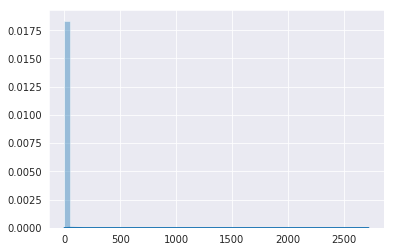

In [44]:
sns.set_style('darkgrid')
sns.distplot(allFlattenedArray)

In [49]:
print('Max Value :',allFlattenedArray.max())
print('Min Value :',allFlattenedArray.min())

Max Value : 2724.9485
Min Value : -0.41025564


In [58]:
checkValue=[0,0.5,1,5,10,15,20,30]
for c_check in checkValue:
    print('Percentage of Pixels greater than ',c_check,' is ',allFlattenedArray[allFlattenedArray > c_check].shape[0]*100.0/allFlattenedArray.shape[0], '%')

Percentage of Pixels greater than  0  is  99.92268939103874 %
Percentage of Pixels greater than  0.5  is  23.339678814398095 %
Percentage of Pixels greater than  1  is  9.279847219510863 %
Percentage of Pixels greater than  5  is  1.3785261011386993 %
Percentage of Pixels greater than  10  is  0.6717221995127102 %
Percentage of Pixels greater than  15  is  0.41461696842754664 %
Percentage of Pixels greater than  20  is  0.2757857521120745 %
Percentage of Pixels greater than  30  is  0.13311489059707562 %


In [100]:
tempArray=allFlattenedArray.copy()
tempArray[tempArray>10]=10
tempArray=tempArray+1.0
print('max value is :',max(tempArray))
print('min value is :',min(tempArray))
bins_1 = np.array([t/10 for t in range(102)])
binning=np.histogram(tempArray, bins=bins_1)
print(binning[0])

max value is : 11.0
min value is : 0.5897443
[      0       0       0       0       0       1       5      14     221
   10511  523784 3317971 3389778 2258510 1160765  683666  474701  343476
  256251  197283  155484  124532  101333   83627   69961   59520   51209
   44193   38526   33782   29958   27033   24045   21569   19523   17841
   16300   14990   13826   12640   11885   10980   10193    9673    8785
    8339    7734    7349    6997    6580    6152    6083    5562    5300
    5044    4855    4664    4484    4281    4047    3837    3581    3632
    3382    3262    3210    3095    2949    2880    2695    2632    2568
    2479    2468    2375    2253    2184    2093    2094    2061    2045
    2002    1815    1702    1795    1771    1694    1612    1551    1585
    1541    1515    1470    1459    1373    1320    1367    1230    1290
    1271    1186]


In [105]:
printing_dictionary={}
for key, val in flattened_DataDictionary.items():
    tempArray=val.copy()
    tempArray[tempArray>10]=10
    tempArray=tempArray+1.0
    bins_1 = np.array([t/10 for t in range(102)])
    binning=np.histogram(tempArray, bins=bins_1)
    str1=key
    str2=str1[:-4]
    distName_st_cen_cd_censuscode=str2.split('@')
    currArray=np.array([int(distName_st_cen_cd_censuscode[1]),int(distName_st_cen_cd_censuscode[2])])
    currArray=np.append(currArray,binning[0])
    printing_dictionary[distName_st_cen_cd_censuscode[0]]=currArray

In [119]:
columns1=['st_cen_cd','censuscode']
col_help=['light_'+str(t) for t in range(101)]
columns1.extend(col_help)
dataframe_districts=pd.DataFrame.from_dict(printing_dictionary, orient='index',columns=columns1)
dataframe_districts.to_csv('2011_districts.csv')

In [113]:
print(columns1)

['st_cen_cd', 'censuscode', 'light_0', 'light_1', 'light_2', 'light_3', 'light_4', 'light_5', 'light_6', 'light_7', 'light_8', 'light_9', 'light_10', 'light_11', 'light_12', 'light_13', 'light_14', 'light_15', 'light_16', 'light_17', 'light_18', 'light_19', 'light_20', 'light_21', 'light_22', 'light_23', 'light_24', 'light_25', 'light_26', 'light_27', 'light_28', 'light_29', 'light_30', 'light_31', 'light_32', 'light_33', 'light_34', 'light_35', 'light_36', 'light_37', 'light_38', 'light_39', 'light_40', 'light_41', 'light_42', 'light_43', 'light_44', 'light_45', 'light_46', 'light_47', 'light_48', 'light_49', 'light_50', 'light_51', 'light_52', 'light_53', 'light_54', 'light_55', 'light_56', 'light_57', 'light_58', 'light_59', 'light_60', 'light_61', 'light_62', 'light_63', 'light_64', 'light_65', 'light_66', 'light_67', 'light_68', 'light_69', 'light_70', 'light_71', 'light_72', 'light_73', 'light_74', 'light_75', 'light_76', 'light_77', 'light_78', 'light_79', 'light_80', 'light_81'

In [108]:
printing_dictionary['Chandigarh'].shape

(103,)

In [25]:
currDistrictFile='districtTiffFiles/Rajkot@24@476.tif'
tif = TIFF.open(currDistrictFile, mode='r')
image = tif.read_image()
dataAll = np.array(image)
dataAll.shape

(368, 329)

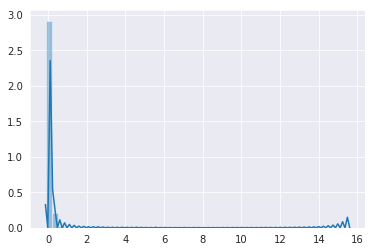